In [1]:
import os
import pandas as pd
from scipy.io import arff
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from additional_functions import (
    add_random_text_column,
    imitate_missing_values_exclude_datetime,
    introduce_missing_values_to_object_column
)
from data_preprocessing import (
    missing_values_handling,
    outlier_detection,
    impute_datawig,
    impute_and_encode_MICE,
    encode_data,
    outlier_detection,
    detect_outliers_ocsvm,
    detect_outliers_lof,
    detect_outliers_iforest,
    detect_outliers_autoencoder
)
from data_preprocessing_default import process_data
from data_preprocessing import (
    interpolate_and_fill,
    spline_interpolate_with_text_fill,
    enhanced_locf_imputation,
    rnn_impute,
    label_encoding,
    detect_outliers_sublof,
    detect_outliers_dtw,
    detect_anomalies_adtk_multivariate
)
import glob
from sklearn.metrics import accuracy_score, classification_report

In [2]:
def evaluate_outliers_time_series(directory, results_folder='time_out_results_f1'):
    """
    Process and evaluate datasets for time series outlier detection, recording both training and testing F1 scores.

    Args:
        directory (str): Path to the directory containing CSV files.
        results_folder (str): Directory to save the results.

    Returns:
        None
    """
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)

    for filepath in glob.glob(os.path.join(directory, '*.csv')):
        filename = os.path.basename(filepath)
        results_path = os.path.join(results_folder, filename.replace('.csv', '_results.csv'))
        df_train, df_test, y_column_name, datetime_col = process_data(train_input=filepath, test_input=None, separator=',', na_values='?', target_var='label', data_type='time', file_type='csv', datetime_col='timestamp')
        df_train, df_test = missing_values_handling(df_train=df_train, df_test=df_test
                                                  , datetime_col=datetime_col, imputation_method='auto'
                                                  , n_steps=10, order=3)
        methods = {
            'sublof': lambda X_train, X_test: detect_outliers_sublof(X_train, X_test, datetime_col, window_size=10),
            'dtw': lambda X_train, X_test: detect_outliers_dtw(X_train, X_test, datetime_col),
            'adtk': lambda X_train, X_test: detect_anomalies_adtk_multivariate(X_train, X_test, datetime_col, window_size=10)
        }

        results = {}
        for method_name, method_function in methods.items():
            X_train_out, X_test_out = method_function(df_train, df_test)
            y_train_pred = (X_train_out.iloc[:, -1] > 0).astype(int)
            y_train_true = df_train[y_column_name].astype(int)
            train_report = classification_report(y_train_true, y_train_pred, output_dict=True, zero_division=0)
            y_test_pred = (X_test_out.iloc[:, -1] > 0).astype(int)
            y_test_true = df_test[y_column_name].astype(int)
            test_report = classification_report(y_test_true, y_test_pred, output_dict=True, zero_division=0)
            results[method_name] = {
                'train_f1': train_report['macro avg']['f1-score'],
                'test_f1': test_report['macro avg']['f1-score']
            }

        results_df = pd.DataFrame(results).T
        results_df.to_csv(results_path)
        print(f"Results for {filename} saved to {results_path}")

evaluate_outliers_time_series('out_datasets_time_csv')

Results for cpu4_timeseries.csv saved to time_out_results_f1\cpu4_timeseries_results.csv
Results for g_timeseries.csv saved to time_out_results_f1\g_timeseries_results.csv
Results for rver_res_eth1out_curve_6_timeseries.csv saved to time_out_results_f1\rver_res_eth1out_curve_6_timeseries_results.csv
Results for server_res_eth1out_curve_61_timeseries.csv saved to time_out_results_f1\server_res_eth1out_curve_61_timeseries_results.csv


In [3]:
def evaluate_outliers_accuracy(directory, results_folder='time_out_results_accuracy'):
    """
    Process and evaluate datasets for time series outlier detection, recording both training and testing accuracy.

    Args:
        directory (str): Path to the directory containing CSV files.
        results_folder (str): Directory to save the results.

    Returns:
        None
    """
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)

    for filepath in glob.glob(os.path.join(directory, '*.csv')):
        filename = os.path.basename(filepath)
        results_path = os.path.join(results_folder, filename.replace('.csv', '_results.csv'))
        df_train, df_test, y_column_name, datetime_col = process_data(
            train_input=filepath, test_input=None, separator=',', na_values='?', target_var='label', data_type='time', file_type='csv', datetime_col='timestamp')
        df_train, df_test = missing_values_handling(df_train=df_train, df_test=df_test
                                                  , datetime_col=datetime_col, imputation_method='auto'
                                                  , n_steps=10, order=3)
        methods = {
            'sublof': lambda X_train, X_test: detect_outliers_sublof(X_train, X_test, datetime_col, window_size=10),
            'dtw': lambda X_train, X_test: detect_outliers_dtw(X_train, X_test, datetime_col),
            'adtk': lambda X_train, X_test: detect_anomalies_adtk_multivariate(X_train, X_test, datetime_col, window_size=10)
        }

        results = {}
        for method_name, method_function in methods.items():
            X_train_out, X_test_out = method_function(df_train, df_test)
            y_train_pred = X_train_out.iloc[:, -1].fillna(0).astype(int)
            y_train_true = df_train[y_column_name].fillna(0).astype(int)
            train_accuracy = accuracy_score(y_train_true, y_train_pred)

            y_test_pred = X_test_out.iloc[:, -1].fillna(0).astype(int)
            y_test_true = df_test[y_column_name].fillna(0).astype(int)
            test_accuracy = accuracy_score(y_test_true, y_test_pred)

            results[method_name] = {
                'train_accuracy': train_accuracy,
                'test_accuracy': test_accuracy
            }
        
        results_df = pd.DataFrame(results).T
        results_df.to_csv(results_path)
        print(f"Results for {filename} saved to {results_path}")
evaluate_outliers_accuracy('out_datasets_time_csv')

Results for cpu4_timeseries.csv saved to time_out_results_accuracy\cpu4_timeseries_results.csv
Results for g_timeseries.csv saved to time_out_results_accuracy\g_timeseries_results.csv
Results for rver_res_eth1out_curve_6_timeseries.csv saved to time_out_results_accuracy\rver_res_eth1out_curve_6_timeseries_results.csv
Results for server_res_eth1out_curve_61_timeseries.csv saved to time_out_results_accuracy\server_res_eth1out_curve_61_timeseries_results.csv


In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

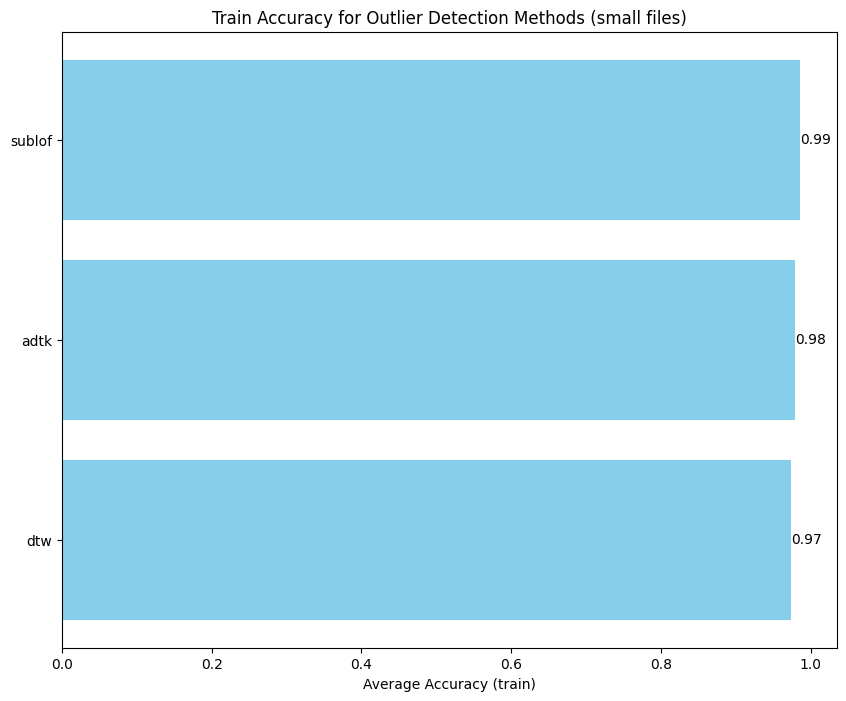

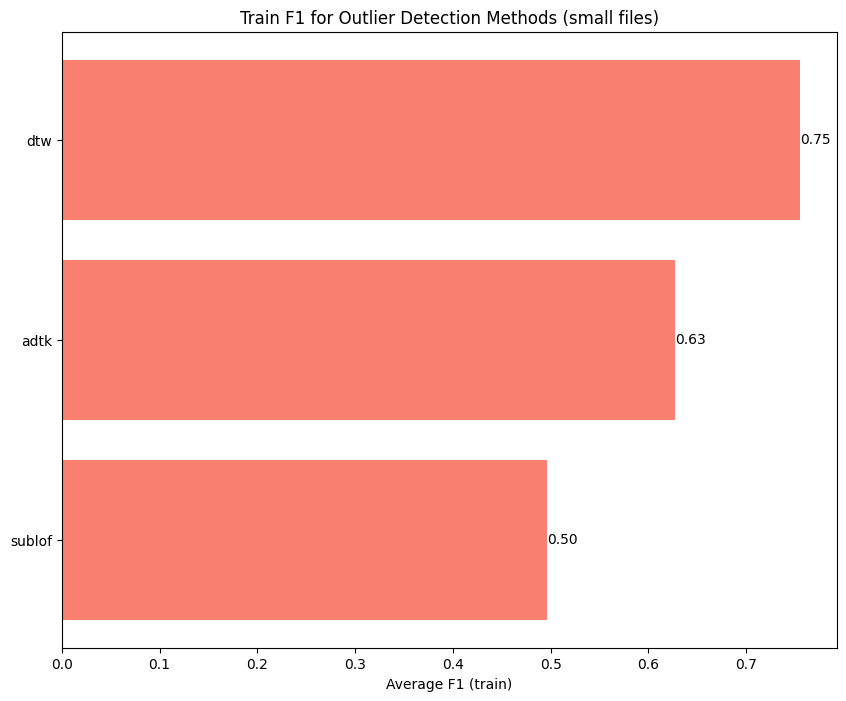

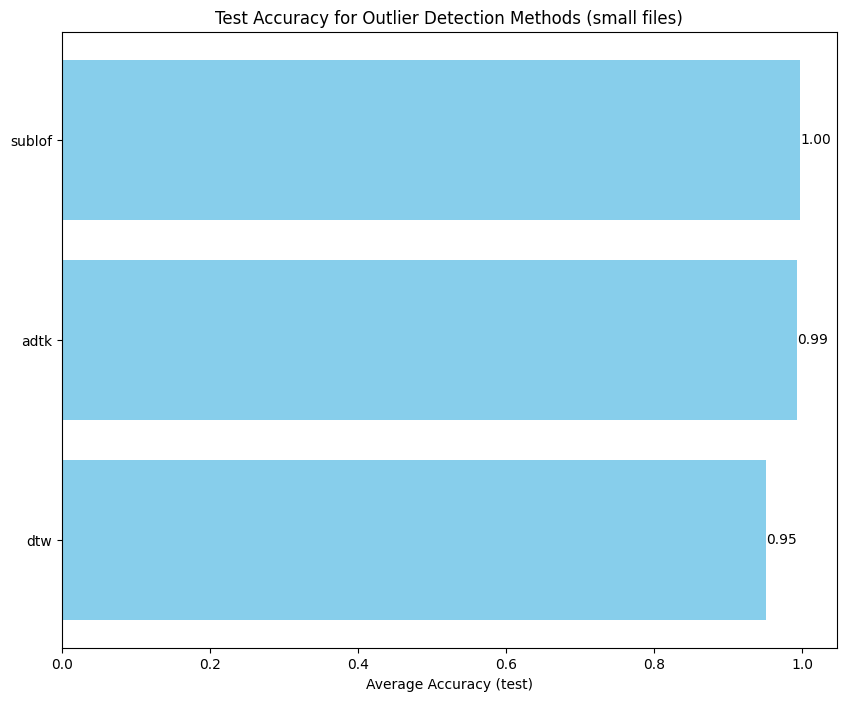

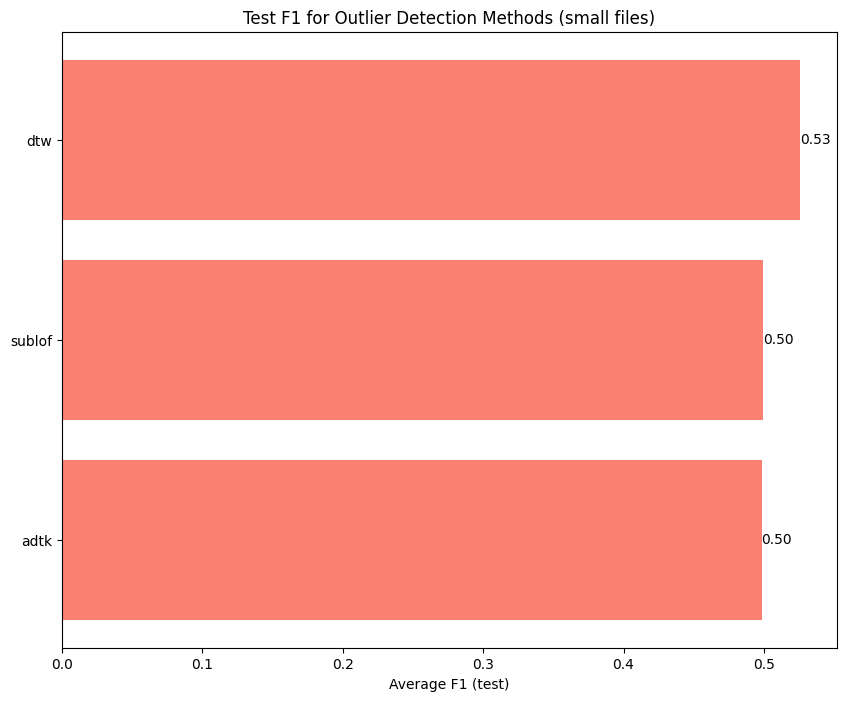

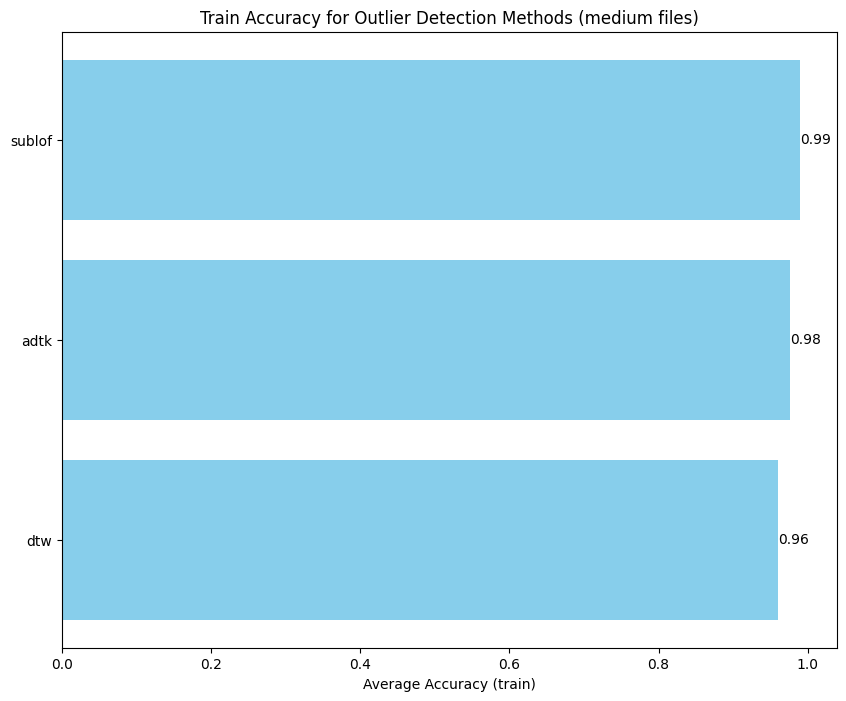

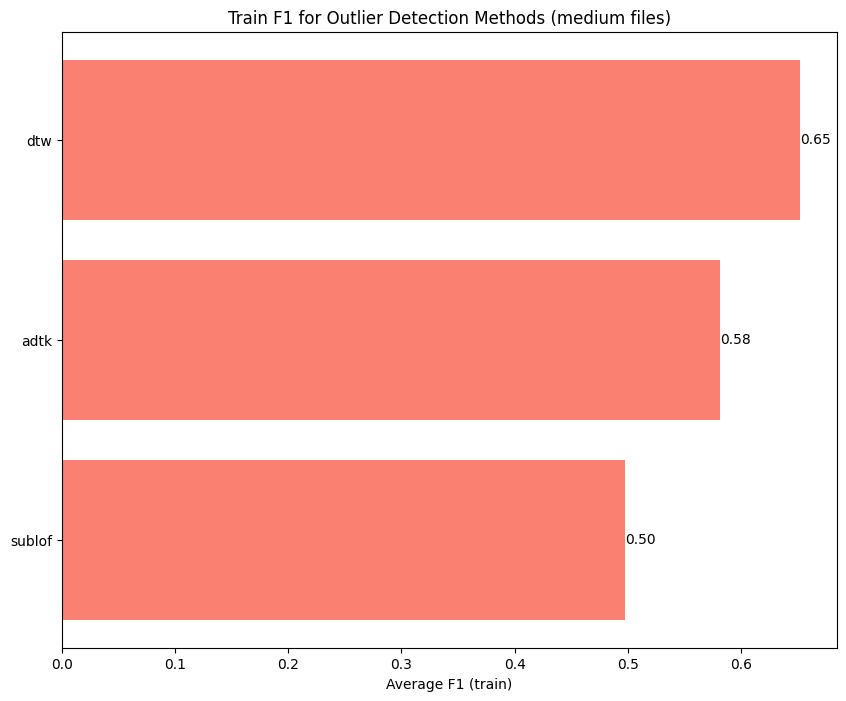

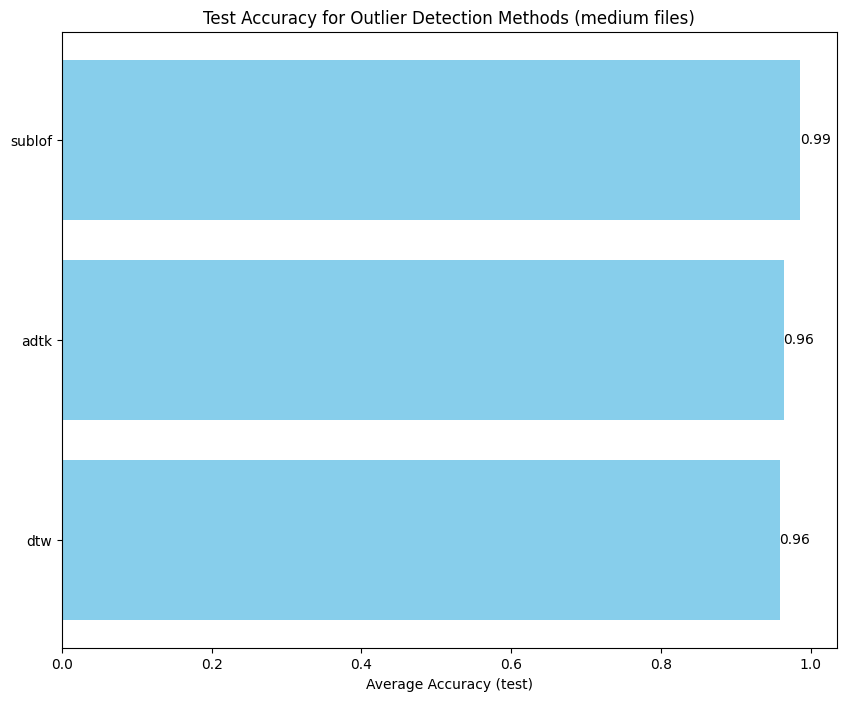

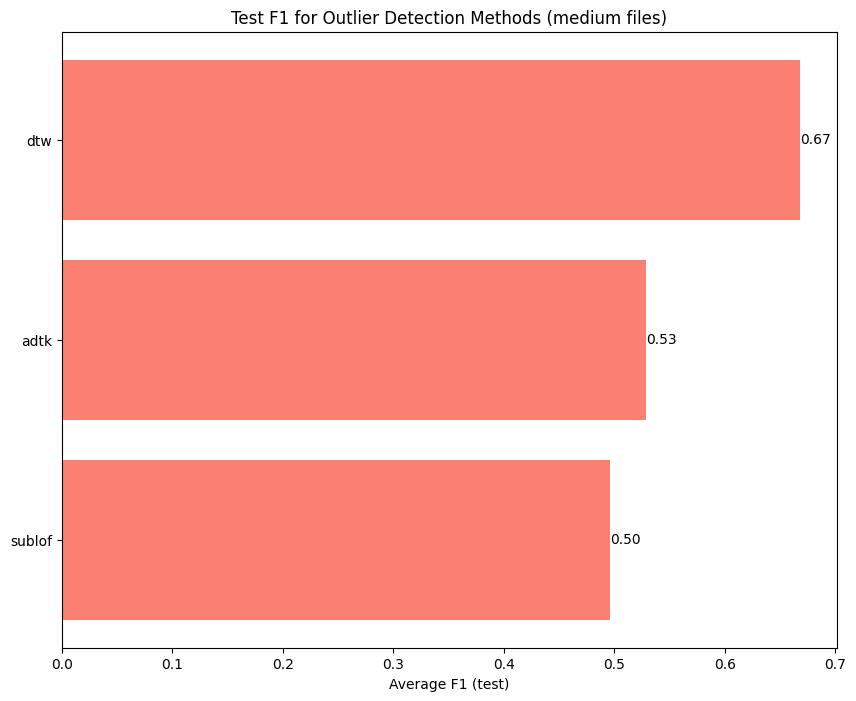

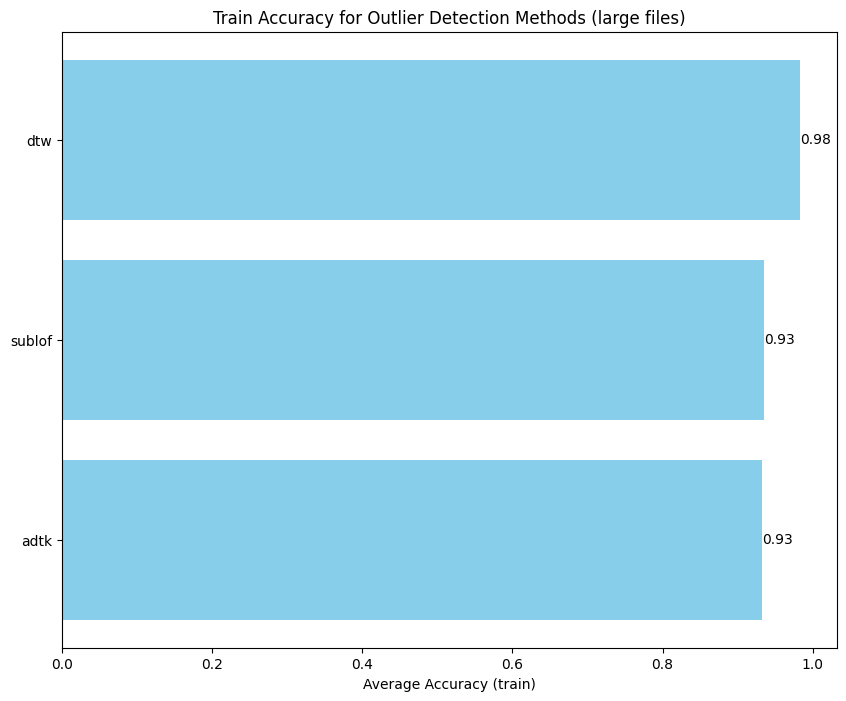

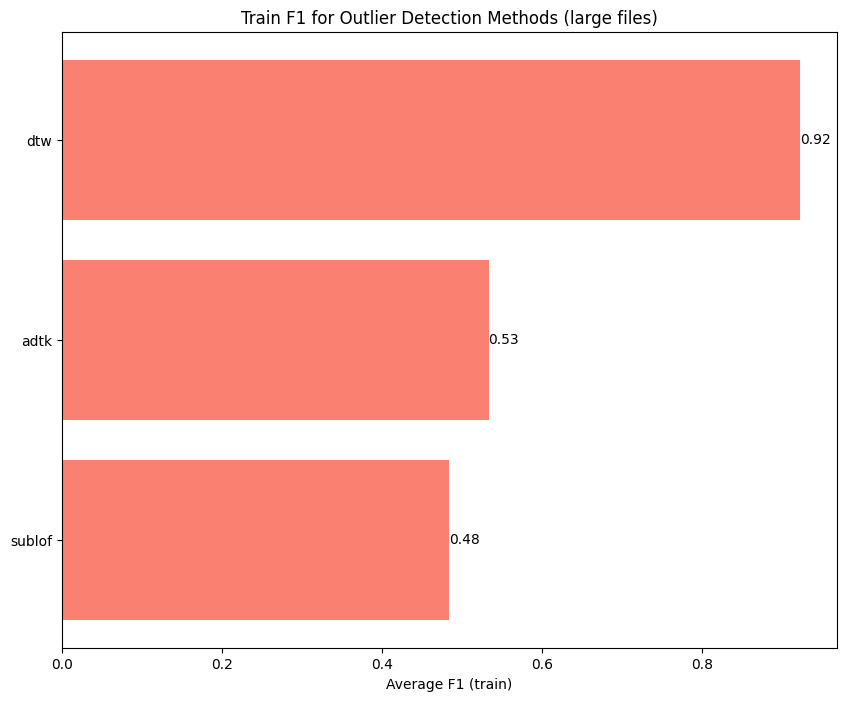

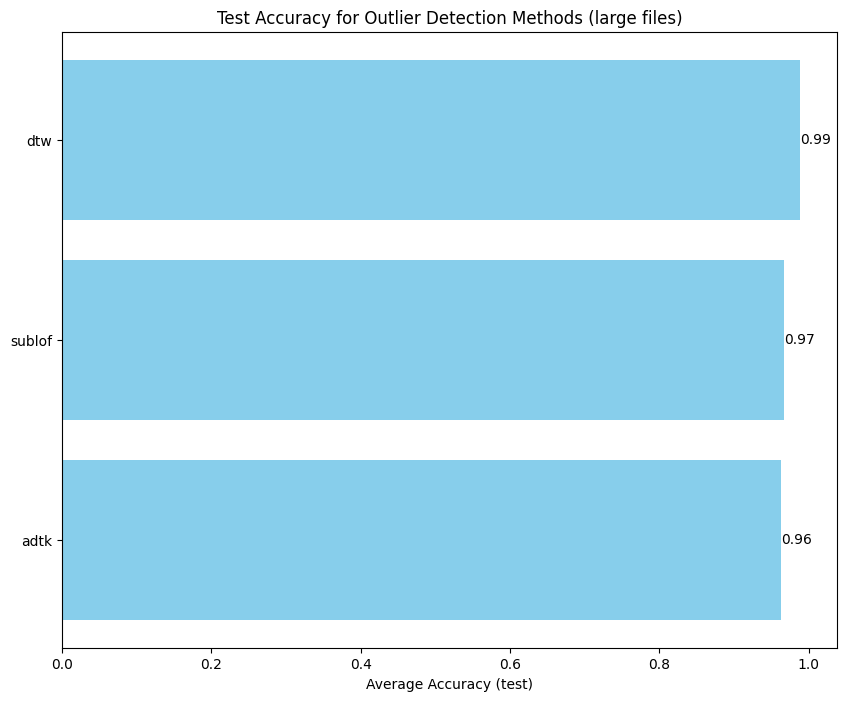

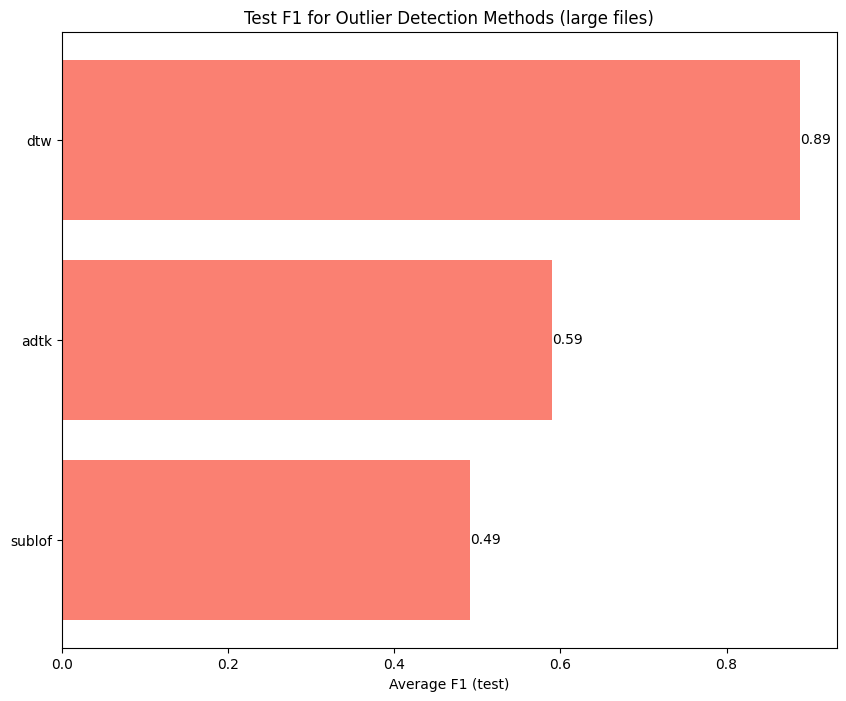

In [5]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_size_category(size):
    if size < 0.7 * 1024 * 1024:  # Smaller than 0.7MB
        return 'small'
    elif size < 5 * 1024 * 1024:  # Smaller than 5MB
        return 'medium'
    else:  # Larger files up to 25MB
        return 'large'

def plot_results(data_folder, results_folder_accuracy, results_folder_f1):
    original_files = glob.glob(os.path.join(data_folder, '*.csv'))
    results = {'small': {}, 'medium': {}, 'large': {}}
    
    for file in original_files:
        base_name = os.path.basename(file)
        file_size = os.path.getsize(file)
        size_category = get_size_category(file_size)
        result_path_accuracy = os.path.join(results_folder_accuracy, base_name.replace('.csv', '_results.csv'))
        result_path_f1 = os.path.join(results_folder_f1, base_name.replace('.csv', '_results.csv'))
        
        if os.path.exists(result_path_accuracy) and os.path.exists(result_path_f1):
            df_accuracy = pd.read_csv(result_path_accuracy, index_col=0)
            df_f1 = pd.read_csv(result_path_f1, index_col=0)
            for method in df_accuracy.index:
                if method not in results[size_category]:
                    results[size_category][method] = {
                        'train_accuracy': [],
                        'test_accuracy': [],
                        'train_f1': [],
                        'test_f1': []
                    }
                results[size_category][method]['train_accuracy'].append(df_accuracy.at[method, 'train_accuracy'])
                results[size_category][method]['test_accuracy'].append(df_accuracy.at[method, 'test_accuracy'])
                results[size_category][method]['train_f1'].append(df_f1.at[method, 'train_f1'])
                results[size_category][method]['test_f1'].append(df_f1.at[method, 'test_f1'])
        else:
            print(f"Missing results for {base_name}")
            
    for size_category in ['small', 'medium', 'large']:
        for dataset_type in ['train', 'test']:
            for metric in ['accuracy', 'f1']:
                plot_data = {method: np.mean(values[f"{dataset_type}_{metric}"]) for method, values in results[size_category].items() if values[f"{dataset_type}_{metric}"]}
                if plot_data:
                    plt.figure(figsize=(10, 8))
                    methods, scores = zip(*sorted(plot_data.items(), key=lambda x: x[1], reverse=True))
                    plt.barh(methods, scores, color='skyblue' if metric == 'accuracy' else 'salmon')
                    plt.xlabel(f'Average {metric.capitalize()} ({dataset_type})')
                    plt.title(f'{dataset_type.capitalize()} {metric.capitalize()} for Outlier Detection Methods ({size_category} files)')
                    plt.gca().invert_yaxis()
                    for index, value in enumerate(scores):
                        plt.text(value, index, f'{value:.2f}', ha='left', va='center')
                    plt.show()
                else:
                    print(f"No data available for {dataset_type} {metric} in {size_category} size category.")

plot_results('out_datasets_time_csv', 'time_out_results_accuracy', 'time_out_results_f1')

In [6]:
def print_results(data_folder, results_folder_accuracy, results_folder_f1):
    original_files = glob.glob(os.path.join(data_folder, '*.csv'))
    results = {'small': {}, 'medium': {}, 'large': {}}
    for file in original_files:
        base_name = os.path.basename(file)
        file_size = os.path.getsize(file)
        size_category = get_size_category(file_size)
        result_path_accuracy = os.path.join(results_folder_accuracy, base_name.replace('.csv', '_results.csv'))
        result_path_f1 = os.path.join(results_folder_f1, base_name.replace('.csv', '_results.csv'))
        
        if os.path.exists(result_path_accuracy) and os.path.exists(result_path_f1):
            df_accuracy = pd.read_csv(result_path_accuracy, index_col=0)
            df_f1 = pd.read_csv(result_path_f1, index_col=0)
            for method in df_accuracy.index:
                if method not in results[size_category]:
                    results[size_category][method] = {
                        'train_accuracy': [],
                        'test_accuracy': [],
                        'train_f1': [],
                        'test_f1': []
                    }
                results[size_category][method]['train_accuracy'].append(df_accuracy.at[method, 'train_accuracy'])
                results[size_category][method]['test_accuracy'].append(df_accuracy.at[method, 'test_accuracy'])
                results[size_category][method]['train_f1'].append(df_f1.at[method, 'train_f1'])
                results[size_category][method]['test_f1'].append(df_f1.at[method, 'test_f1'])
        else:
            print(f"Missing results for {base_name}")
    for size_category in ['small', 'medium', 'large']:
        print(f"--- {size_category.upper()} FILES ---")
        for method, values in results[size_category].items():
            print(f"Results for {method}:")
            for metric, scores in values.items():
                if scores:
                    mean_score = np.mean(scores)
                    print(f"  {metric} average: {mean_score:.4f}")
                else:
                    print(f"  {metric} average: No data")
            print()
print_results('out_datasets_time_csv', 'time_out_results_accuracy', 'time_out_results_f1')

--- SMALL FILES ---
Results for sublof:
  train_accuracy average: 0.9854
  test_accuracy average: 0.9972
  train_f1 average: 0.4963
  test_f1 average: 0.4993

Results for dtw:
  train_accuracy average: 0.9738
  test_accuracy average: 0.9516
  train_f1 average: 0.7549
  test_f1 average: 0.5256

Results for adtk:
  train_accuracy average: 0.9792
  test_accuracy average: 0.9932
  train_f1 average: 0.6275
  test_f1 average: 0.4983

--- MEDIUM FILES ---
Results for sublof:
  train_accuracy average: 0.9895
  test_accuracy average: 0.9853
  train_f1 average: 0.4973
  test_f1 average: 0.4963

Results for dtw:
  train_accuracy average: 0.9604
  test_accuracy average: 0.9582
  train_f1 average: 0.6520
  test_f1 average: 0.6681

Results for adtk:
  train_accuracy average: 0.9762
  test_accuracy average: 0.9634
  train_f1 average: 0.5817
  test_f1 average: 0.5287

--- LARGE FILES ---
Results for sublof:
  train_accuracy average: 0.9348
  test_accuracy average: 0.9673
  train_f1 average: 0.4831
  t